In [96]:
# Import files
import numpy as np  
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt

In [97]:
# goal is reward is reward when we goal, normal reward is reward foe each step, draw reward is reward when we draw
GOAL_REWARD = 10
NORMAL_REWARD = -1
DRAW_REWARD = -3

In [98]:
# this function is used to get the initial position of the agent
def get_init_posn(h, w):
    h1= np.random.randint(0, h)
    w1 = np.random.randint(0, w)
    return np.array([w1, h1])

In [99]:
# Soccer environment
class Soccer:
    '''
    Actions [0 : Left, 1 : Up, 2 : Right, 3 : Down, 4 : Stand]
    '''
    def __init__(self, h=4, w=5, pA=[3, 2], pB=[1, 1], goalPositions=[1, 2], ballOwner=0, drawProbability=0):
        self.h = h
        self.w = w
        self.goalPositions = np.array(goalPositions)
        self.positions = np.array([get_init_posn(h, w), get_init_posn(h, w)])
        self.initPositions = self.positions
        self.ballOwner = ballOwner
        self.drawProbability = drawProbability
        self.rewards = np.array([0, 0])

    def reset(self, pA=None, pB=None, ballOwner=None):
        if pA is not None:
            self.initPositions[0] = pA

        if pB is not None:
            self.initPositions[1] = pB

        if ballOwner is None:
            ballOwner = self.choosePlayer()

        self.positions = np.array([get_init_posn(self.h, self.w), get_init_posn(self.h, self.w)])
        self.ballOwner = ballOwner
        return np.array([self.positions[0][0]/self.w ,self.positions[0][1]/self.h]) ,np.array([self.positions[1][0]/self.w ,self.positions[1][1]/self.h]), self.ballOwner

    # wrapper function for move
    def _move(self, actionA, actionB):
        reward = DRAW_REWARD
        if np.random.rand() < self.drawProbability:
            return np.array([self.positions[0][0]/self.w ,self.positions[0][1]/self.h]) ,np.array([self.positions[1][0]/self.w ,self.positions[1][1]/self.h]), self.ballOwner, reward, reward, True
        first = self.choosePlayer()
        actions = [actionA, actionB]
        m1 = self.move(first, actions[first])
        if m1[-1]: return m1
        return self.move(1 - first, actions[1 - first])

    def move(self, player, action):
        opponent = 1 - player
       
        newPosition = self.positions[player] + self.actionToMove(action)

        reward = NORMAL_REWARD
        # If it's opponent position
        if (newPosition == self.positions[opponent]).all():
            self.ballOwner = opponent
        # If it's the goal
        elif self.ballOwner is player and self.isInGoal(*newPosition) >= 0:
            reward = -2 * (1 - self.isInGoal(*newPosition)) + 1
            reward *= GOAL_REWARD
            return np.array([self.positions[0][0]/self.w ,self.positions[0][1]/self.h]) ,np.array([self.positions[1][0]/self.w ,self.positions[1][1]/self.h]), self.ballOwner, reward, -reward, True
        # If it's in board
        elif self.isInBoard(*newPosition):
            self.positions[player] = newPosition
        return np.array([self.positions[0][0]/self.w ,self.positions[0][1]/self.h]) ,np.array([self.positions[1][0]/self.w ,self.positions[1][1]/self.h]), self.ballOwner, reward, reward, False

    def actionToMove(self, action):
        switcher = {
            0: [-1, 0],
            1: [0, 1],
            2: [1, 0],
            3: [0, -1],
            4: [0, 0],
        }
        return switcher.get(action)

    def isInGoal(self, x, y):
        g1, g2 = self.goalPositions
        if (g1 <= y <= g2):
            if x == -1:
                return 1
            elif x == self.w:
                return 0
        return -1

    def isInBoard(self, x, y):
        return (0 <= x < self.w and 0 <= y < self.h)

    def choosePlayer(self):
        return np.random.randint(0, 2)

    def draw(self, positions=None, ballOwner=None):
        positions = self.positions if positions is None else np.array(positions)
        ballOwner = self.ballOwner if ballOwner is None else ballOwner

        board = ''
        for y in range(self.h)[::-1]:
            for x in range(self.w):
                if ([x, y] == positions[0]).all():
                    board += 'A' if ballOwner == 0 else 'a'
                elif ([x, y] == positions[1]).all():
                    board += 'B' if ballOwner == 1 else 'b'
                else:
                    board += '-'
            board += '\n'

        print(board)



In [100]:
# Neural net for our DQN
class Net(nn.Module):
    def __init__(self,seed,input_dimension=6):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dimension, 64)  
        self.fc2 = nn.Linear(64, 64)  
        self.fc3 = nn.Linear(64, 1) 
        torch.manual_seed(seed)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def train(self,input_ls,label_ls,lr=0.03):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for i in range(len(input_ls)):
            inputs = torch.tensor(input_ls[i],dtype=torch.float)
            labels = label_ls[i]
            optimizer.zero_grad()
            outputs = self.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
# Q network class having target and online network and a replay memory
class Q_network:
    def __init__(self,max_cap=1000):
        seed = random.randint(0, 1000)
        self.target_network = self.build_model(seed)
        self.online_network = self.build_model(seed)
        self.replay_memory = deque()
    def build_model(self,seed):
        model = Net(seed=seed)
        return model
    

In [101]:
num_actions= 5

In [102]:
# epsilon greedy policy
def epsilon_greedy(Q_network,state,epsilon):
    if random.random() < epsilon:
        return random.randint(0,num_actions-1)
    else:
        Q_values = []
        for i in range(num_actions):
            state_action = np.concatenate((state,np.array([i])),axis=0)
            Q_value = Q_network.online_network.forward(torch.Tensor(state_action))
            Q_values.append((Q_value,i))
        Q_values.sort(reverse=True)
        return Q_values[0][1]

# Intialize the environment and the Q network and paramters
env = Soccer(drawProbability=0.005)
player_A = Q_network()
player_B = Q_network()
num_episodes = 3000             # Number of episodes
epochs = 500                    # Number of max epochs in an episode
frequency = 10                  # Frequency of updating target network
epsilon=0.3                     # Epsilon for epsilon greedy policy
stochastic_param=10             # Number of samples to be taken from replay memory
gamma=1                         # Discount factor
buffer_ln = 100                 # Buffer length
fill_memory = 20                # Number of epochs to fill the replay memory
wins_A = []                     # List to store wins of player A
wins_B = []                     # List to store wins of player B
episode_ln=[]                   # List to store the length of each episode
cnt_epoch_ended = 0             # Count of episodes ended before any result
learning_rate = 0.01            # Learning rate
cnt_A_win_A_goal = 0
cnt_B_win_B_goal = 0
cnt_A_win_B_goal = 0
cnt_B_win_A_goal = 0
cnt_draw=0
for episode in range(num_episodes):
    current_state_A,current_state_B,BallOwner = env.reset()
    for epoch in range(epochs):
        # Pickup the action
        action_A = epsilon_greedy(player_A,np.concatenate((current_state_A,current_state_B,np.array([BallOwner])),axis=0),1)
        action_B = epsilon_greedy(player_B,np.concatenate((current_state_A,current_state_B,np.array([BallOwner])),axis=0),epsilon)
        
        # Get the next state and reward
        result = env._move(action_A,action_B)
        next_state_A,next_state_B,next_BallOwner,reward_A,reward_B,done_env = result
        
        # Append the state, action, reward, next state and done to the replay memory
        if(len(list(player_A.replay_memory))>buffer_ln):
            player_A.replay_memory.popleft()
        player_A.replay_memory.append((np.concatenate((current_state_A,current_state_B,np.array([BallOwner])),axis=0),action_A,reward_A,np.concatenate((next_state_A, next_state_B,np.array([next_BallOwner])),axis=0),done_env))
        
        if(len(list(player_B.replay_memory))>buffer_ln):
            player_B.replay_memory.popleft()
        player_B.replay_memory.append((np.concatenate((current_state_A,current_state_B,np.array([BallOwner])),axis=0),action_B,reward_B,np.concatenate((next_state_A, next_state_B,np.array([next_BallOwner])),axis=0),done_env))
        
        current_state_A = next_state_A
        current_state_B = next_state_B
        
        # Wait till fill memory is filled to a certain extent
        if epoch < fill_memory and episode == 0:
            continue
        else:
            # Sample the replay memory and train the network
            sample_for_A = random.sample(list(player_A.replay_memory), min(len(list(player_A.replay_memory)) ,(stochastic_param)))
            sample_for_B = random.sample(list(player_B.replay_memory), min(len(list(player_B.replay_memory)) ,(stochastic_param)))
            input_ls=[]
            label_ls=[]
            for sample in sample_for_A:
                state,action,reward,next_state,done = sample
                if done:
                    target = torch.tensor([reward],dtype=torch.float)
                else:
                    target = reward + gamma*max([player_A.target_network.forward(torch.Tensor(np.concatenate((next_state,[i]),axis=0))) for i in range(num_actions)])
                input_ls.append(np.concatenate((state,[action]),axis=0))
                label_ls.append(target)
            # player_A.online_network.train(input_ls,label_ls,learning_rate)
            input_ls=[]
            label_ls=[]
            for sample in sample_for_B:
                state,action,reward,next_state,done = sample
                if done:
                    target = torch.tensor([reward],dtype=torch.float)
                else:
                    target = reward + gamma*max([player_B.target_network.forward(torch.Tensor(np.concatenate((next_state,[i]),axis=0))) for i in range(num_actions)])
                input_ls.append(np.concatenate((state,[action]),axis=0))
                label_ls.append(target)
            player_B.online_network.train(input_ls,label_ls,learning_rate)
        # Update the target network
        if epoch%frequency==0:
            player_A.target_network.load_state_dict(player_A.online_network.state_dict())
            player_B.target_network.load_state_dict(player_B.online_network.state_dict())
        if done_env:
            if episode%10==0:
                print("Episode number when done: ",episode)
            if episode%100==0:
                print("Episode number when done: ",episode)
                print("A wins and A goal: ",cnt_A_win_A_goal)
                print("B wins and B goal: ",cnt_B_win_B_goal)
                print("A wins and B goal: ",cnt_A_win_B_goal)
                print("B wins and A goal: ",cnt_B_win_A_goal)
                print("Draws: ",cnt_draw)
                cnt_A_win_A_goal = 0
                cnt_B_win_B_goal = 0
                cnt_A_win_B_goal = 0
                cnt_B_win_A_goal = 0
                cnt_draw=0
            if reward_A == GOAL_REWARD:
                if next_BallOwner==0:
                    cnt_A_win_A_goal+=1
                else:
                    cnt_A_win_B_goal+=1
                wins_A.append(1)
                wins_B.append(0)
            elif reward_B == GOAL_REWARD:
                if next_BallOwner==1:
                    cnt_B_win_B_goal+=1
                else:
                    cnt_B_win_A_goal+=1
                wins_A.append(0)
                wins_B.append(1)
            else:
                cnt_draw+=1
                wins_A.append(0)
                wins_B.append(0)
            episode_ln.append(epoch)
            break 
        if epoch==epochs-1:
            wins_A.append(0)
            wins_B.append(0)
            cnt_epoch_ended+=1
# Plot for comparision of wins of both players
plt.plot(np.cumsum(np.array(wins_A)),label='Player A')
plt.plot(np.cumsum(np.array(wins_B)),label='Player B')
plt.xlabel('Episodes')
plt.ylabel('No of Wins')
plt.legend()
plt.show()
print("Average length of episodes: ",np.mean(np.array(episode_ln)))


Episode number when done:  0
Episode number when done:  0
A wins and A goal:  0
B wins and B goal:  0
A wins and B goal:  0
B wins and A goal:  0
Draws:  0
Episode number when done:  10
Episode number when done:  20
Episode number when done:  30
Episode number when done:  40
Episode number when done:  50
Episode number when done:  60
Episode number when done:  70
Episode number when done:  80
Episode number when done:  90
Episode number when done:  100
Episode number when done:  100
A wins and A goal:  11
B wins and B goal:  6
A wins and B goal:  53
B wins and A goal:  17
Draws:  13
Episode number when done:  110
Episode number when done:  120
Episode number when done:  130
Episode number when done:  140
Episode number when done:  150
Episode number when done:  160
Episode number when done:  170
Episode number when done:  180
Episode number when done:  190
Episode number when done:  200
Episode number when done:  200
A wins and A goal:  27
B wins and B goal:  13
A wins and B goal:  32


In [71]:
print(sum(episode_ln)/len(episode_ln))

75.80602006688963


In [45]:
player_A_temp=player_A
player_B_temp=player_B

Episode number when done:  0
Player B wins and goal was done by:  B
Player A wins and goal was done by:  B
Player A wins and goal was done by:  B
Player B wins and goal was done by:  A
Player A wins and goal was done by:  A
Draw
Player B wins and goal was done by:  A
Player B wins and goal was done by:  B
Player B wins and goal was done by:  B
Draw
Episode number when done:  10
Player B wins and goal was done by:  A
Player B wins and goal was done by:  B
Draw
Draw
Player B wins and goal was done by:  A
Player A wins and goal was done by:  A
Player B wins and goal was done by:  A
Player A wins and goal was done by:  B
Player B wins and goal was done by:  B
Draw
Episode number when done:  20
Player A wins and goal was done by:  A
Player A wins and goal was done by:  B
Player A wins and goal was done by:  B
Player A wins and goal was done by:  A
Player B wins and goal was done by:  B
Draw
Draw
Player A wins and goal was done by:  B
Player B wins and goal was done by:  A
Player A wins and 

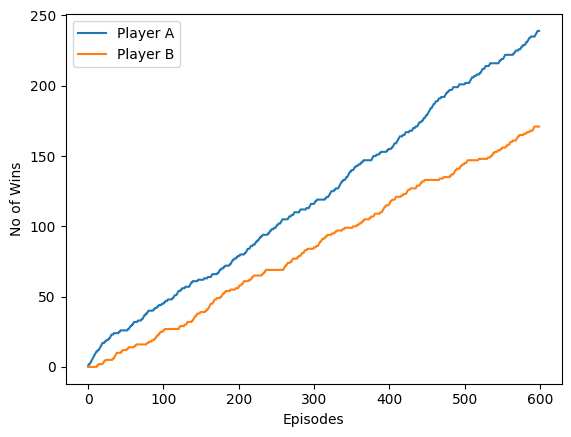

0


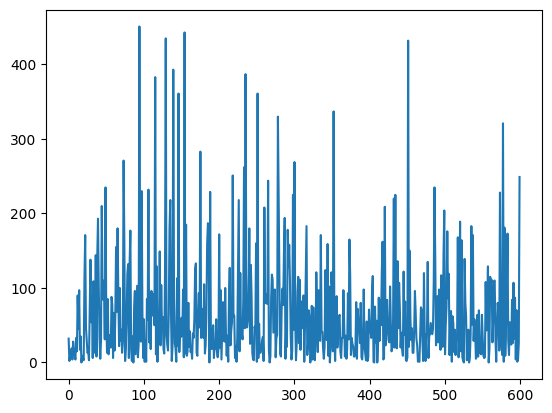

In [46]:
for episode in range(num_episodes):
    current_state_A,current_state_B,BallOwner = env.reset()
    for epoch in range(epochs):
        action_A = epsilon_greedy(player_A,np.concatenate((current_state_A,current_state_B,np.array([BallOwner])),axis=0),epsilon)
        action_B = epsilon_greedy(player_B,np.concatenate((current_state_A,current_state_B,np.array([BallOwner])),axis=0),1)
        # print("Starting epoch and episode: ",epoch,episode)
        # print("Actions taken by A and B: ",action_A,action_B)
        # print("Current state of A and B: ",np.multiply(current_state_A,np.array([5,4])),np.multiply(current_state_B,np.array([5,4])))
        # env.draw()
        result = env._move(action_A,action_B)
        next_state_A,next_state_B,next_BallOwner,reward_A,reward_B,done_env = result
        if(len(list(player_A.replay_memory))>buffer_ln):
            player_A.replay_memory.popleft()
        player_A.replay_memory.append((np.concatenate((current_state_A,current_state_B,np.array([BallOwner])),axis=0),action_A,reward_A,np.concatenate((next_state_A, next_state_B,np.array([next_BallOwner])),axis=0),done_env))
        if(len(list(player_B.replay_memory))>buffer_ln):
            player_B.replay_memory.popleft()
        player_B.replay_memory.append((np.concatenate((current_state_A,current_state_B,np.array([BallOwner])),axis=0),action_B,reward_B,np.concatenate((next_state_A, next_state_B,np.array([next_BallOwner])),axis=0),done_env))
        current_state_A = next_state_A
        current_state_B = next_state_B
        # if epoch < fill_memory and episode == 0:
        #     continue
        # else:
        #     sample_for_A = random.sample(list(player_A.replay_memory), min(len(list(player_A.replay_memory)) ,(stochastic_param)))
        #     sample_for_B = random.sample(list(player_B.replay_memory), min(len(list(player_B.replay_memory)) ,(stochastic_param)))
        #     input_ls=[]
        #     label_ls=[]
        #     for sample in sample_for_A:
        #         state,action,reward,next_state,done = sample
        #         if done:
        #             target = torch.tensor([reward],dtype=torch.float)
        #         else:
        #             target = reward + gamma*max([player_A.target_network.forward(torch.Tensor(np.concatenate((next_state,[i]),axis=0))) for i in range(num_actions)])
        #         input_ls.append(np.concatenate((state,[action]),axis=0))
        #         label_ls.append(target)
        #     player_A.online_network.train(input_ls,label_ls)
        #     input_ls=[]
        #     label_ls=[]
        #     for sample in sample_for_B:
        #         state,action,reward,next_state,done = sample
        #         if done:
        #             target = torch.tensor([reward],dtype=torch.float)
        #         else:
        #             target = reward + gamma*max([player_B.target_network.forward(torch.Tensor(np.concatenate((next_state,[i]),axis=0))) for i in range(num_actions)])
        #         input_ls.append(np.concatenate((state,[action]),axis=0))
        #         label_ls.append(target)
        #     # print("Going to train for epoch and episode: ",epoch,episode)
        #     player_B.online_network.train(input_ls,label_ls)
        # if epoch%frequency==0:
        #     player_A.target_network.load_state_dict(player_A.online_network.state_dict())
        #     player_B.target_network.load_state_dict(player_B.online_network.state_dict())
        if done_env:
            if episode%10==0:
                print("Episode number when done: ",episode)
            if reward_A == GOAL_REWARD:
                print("Player A wins and goal was done by: ",np.array(['A','B'])[next_BallOwner])
                wins_A.append(1)
                wins_B.append(0)
            elif reward_B == GOAL_REWARD:
                print("Player B wins and goal was done by: ",np.array(['A','B'])[next_BallOwner])
                wins_A.append(0)
                wins_B.append(1)
            else:
                print("Draw")
                wins_A.append(0)
                wins_B.append(0)
            episode_ln.append(epoch)
            break 
        if epoch==epochs-1:
            wins_A.append(0)
            wins_B.append(0)
            cnt_epoch_ended+=1
plt.plot(np.cumsum(np.array(wins_A)),label='Player A')
plt.plot(np.cumsum(np.array(wins_B)),label='Player B')
plt.xlabel('Episodes')
plt.ylabel('No of Wins')
plt.legend()
plt.show()
plt.plot(episode_ln)
print(cnt_epoch_ended)